# 2D Occlusion with MNIST

In [1]:
!python --version

Python 3.7.13


Populating the interactive namespace from numpy and matplotlib
11501568/11490434 [==============================] - 0s 0us/step


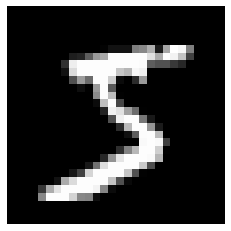

In [2]:
%pylab inline
import os
import numpy as np
import pandas as pd
# from scipy.misc import imread
from imageio import imread
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D

from keras.datasets import mnist

# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

(train_x, train_y), (test_x, test_y) = mnist.load_data()

img = train_x[0]

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

# temp = []
# for img_name in train['filename']:
#     image_path = os.path.join(data_dir, 'train', img_name)
#     img = imread(image_path, flatten=True)
#     img = img.astype('float32')
#     temp.append(img)


In [3]:
train_x = train_x/255.0
train_x = train_x.reshape(-1, 28, 28, 1).astype('float32')

test_x = test_x/255.0
test_x = test_x.reshape(-1, 28, 28, 1).astype('float32')

train_y = keras.utils.np_utils.to_categorical(train_y)

split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [4]:
# define vars

epochs = 5
batch_size = 128

# import keras modules

from keras.models import Sequential
from keras.layers import Dense

# create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name='preds'))


# compile the model with necessary attributes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model = model.fit(train_x, train_y, 
                          epochs=epochs, 
                          batch_size=batch_size, 
                          validation_data=(val_x, val_y))

Epoch 1/5
329/329 [==============================] - 115s 346ms/step - loss: 0.2824 - accuracy: 0.9149 - val_loss: 0.0769 - val_accuracy: 0.9772
Epoch 2/5
329/329 [==============================] - 108s 327ms/step - loss: 0.0973 - accuracy: 0.9707 - val_loss: 0.0587 - val_accuracy: 0.9819
Epoch 3/5
329/329 [==============================] - 107s 324ms/step - loss: 0.0691 - accuracy: 0.9791 - val_loss: 0.0461 - val_accuracy: 0.9860
Epoch 4/5
329/329 [==============================] - 106s 323ms/step - loss: 0.0576 - accuracy: 0.9825 - val_loss: 0.0429 - val_accuracy: 0.9864
Epoch 5/5
329/329 [==============================] - 106s 323ms/step - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.0452 - val_accuracy: 0.9867


In [5]:
pred = model.predict(test_x)

Prediction is:  9


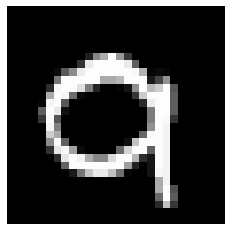

In [27]:
indx = 20
print ("Prediction is: ", np.argmax(pred[indx]))

pylab.imshow(np.squeeze(val_x[indx]), cmap='gray')
pylab.axis('off')
pylab.show()

In [31]:
def iter_occlusion(image, size=8):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

   occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
   occlusion_center = np.full((size, size, 1), [0.5], np.float32)
   occlusion_padding = size * 2

   # print('padding...')
   image_padded = np.pad(image, ( \
   (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
   ), 'constant', constant_values = 0.0)

   for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

       for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
           tmp = image_padded.copy()

           tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

           tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

           yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

i = 20 # for example
data = val_x[i]
correct_class = np.argmax(val_y[i])

# input tensor for model.predict
inp = data.reshape(1, 28, 28, 1)

# image data for matplotlib's imshow
img = data.reshape(28, 28)

# occlusion
img_size = img.shape[0]
occlusion_size = 4

print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):
    X = img_float.reshape(1, 28, 28, 1)
    out = model.predict(X)
    # print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    # print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))
    # plt.imshow(np.squeeze(X), cmap="gray", vmin = 0, vmax = 1)
    # plt.show()

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

occluding...


In [28]:
def iter_occlusion(image, size=4, stride = None):

  if stride is None:
    stride = size
  elif stride > size:
    raise ValueError('stride must be smaller or equal size')
  
  if stride == size:
    if (not (image.shape[0] / size).is_integer() or
        not (image.shape[1] / size).is_integer()):
      
      raise ValueError('size does not work with this image')
  elif stride != size:
    if (((image.shape[0]-size) % stride) != 0 or 
        ((image.shape[0]-size) % stride) != 0):
      
      raise ValueError('shape and size do not match')


  occlusion_center = np.full((size, size, 1), [0.5], np.float32)

  for y in range(0, image.shape[0]-size+1, stride):
    for x in range(0, image.shape[1]-size+1, stride):
      tmp = image.copy()

      tmp[y:y + size, x:x + size] = occlusion_center

      yield x, y, tmp
  
i = 20 # for example
data = val_x[i]
correct_class = np.argmax(val_y[i])

# image data for matplotlib's imshow
img = data.reshape(28, 28)

# occlusion
occlusion_size = 10
occlusion_stride = 2
num_occlusion =  int(np.prod(((np.array(img.shape[0:2]) - occlusion_size) / occlusion_stride) + 1))

print('occluding...')

heatmap_n = np.empty((num_occlusion, img.shape[0], img.shape[1]), np.float32)
heatmap_n[:] = np.nan
class_pixels_n = np.empty((num_occlusion, img.shape[0], img.shape[1]), np.float32)
class_pixels_n[:] = np.nan

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size, stride = occlusion_stride)):
    X = img_float.reshape(1, 28, 28, 1)
    out = model.predict(X)
    # print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    # print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))
    # plt.imshow(np.squeeze(X), cmap="gray", vmin = 0, vmax = 1)
    # plt.show()

    # print(n)
    heatmap_n[n, y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels_n[n, y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

occluding...


In [29]:
from scipy import stats

heatmap = np.mean(np.ma.array(heatmap_n, mask=np.isnan(heatmap_n)), axis = 0)
class_pixels = np.reshape(stats.mode(class_pixels_n, axis = 0, nan_policy = "omit")[0], (img.shape))

In [10]:
data.shape

(28, 28, 1)

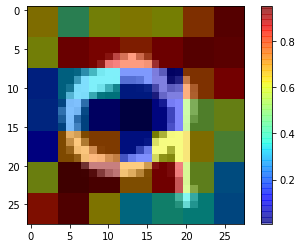

In [32]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.colorbar()

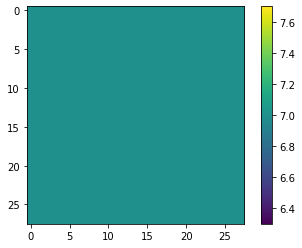

In [17]:
plt.imshow(class_pixels)
plt.colorbar()

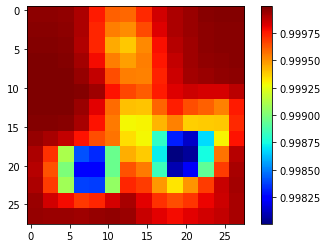

In [18]:
plt.imshow(heatmap, cmap='jet')
plt.colorbar()